In [1]:
#GeForce GTX 1060	6.1  cant benefit from mixed precision training it requires 7 + compute capability

In [2]:
import tensorflow as tf

In [3]:
#!nvidia-smi -L
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.get_device_details(physical_devices[0])


{'device_name': 'NVIDIA GeForce GTX 1060 6GB', 'compute_capability': (6, 1)}

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("plant_village" in datasets_list) # is our target dataset in the list of TFDS datasets?
     

True


In [7]:
#The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease.
(train_data, test_data), ds_info = tfds.load(name="plant_village",
                                             split=["train[:80%]","train[80%:]"], #https://www.tensorflow.org/datasets/splits 
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

In [8]:
len(train_data)

43442

In [9]:
len(test_data)

10861

In [10]:
#test data 20 percent hai total data mae sae , jaise humne upar indexing kiya 0 sae 80% train ko aur 80% sae aage vale test ko
(len(test_data)/(len(train_data)+len(test_data)))*100

20.00073660755391

In [11]:
43442+10861

54303

In [12]:
#https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/plant_village/plant_village_dataset_builder.py
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=38),
})

In [13]:
class_names=ds_info.features["label"].names #names give proper output otherwise voh classLabel hei rehta

In [14]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat

In [15]:
train_one_sample=train_data.take(1)

In [16]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (256, 256, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 15
  Class name (str form): Orange___Haunglongbing_(Citrus_greening)
  


(-0.5, 255.5, 255.5, -0.5)

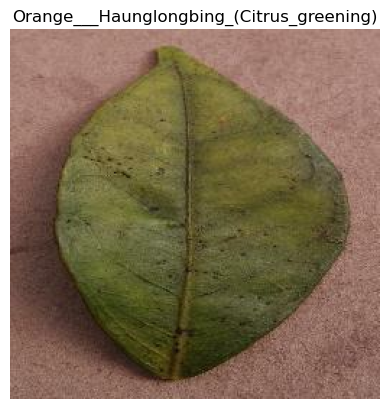

In [18]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [19]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=197>)

In [20]:
image

<tf.Tensor: shape=(256, 256, 3), dtype=uint8, numpy=
array([[[168, 130, 119],
        [168, 130, 119],
        [167, 129, 118],
        ...,
        [177, 139, 130],
        [174, 136, 127],
        [171, 133, 124]],

       [[170, 132, 121],
        [172, 134, 123],
        [174, 136, 125],
        ...,
        [176, 138, 129],
        [174, 136, 127],
        [173, 135, 126]],

       [[170, 132, 121],
        [173, 135, 124],
        [177, 139, 128],
        ...,
        [171, 133, 124],
        [170, 132, 123],
        [170, 132, 123]],

       ...,

       [[131,  97,  85],
        [140, 106,  94],
        [150, 116, 104],
        ...,
        [146, 112, 102],
        [139, 105,  95],
        [147, 113, 103]],

       [[145, 111,  99],
        [151, 117, 105],
        [134, 100,  88],
        ...,
        [150, 116, 106],
        [151, 117, 107],
        [171, 137, 127]],

       [[131,  97,  85],
        [148, 114, 102],
        [130,  96,  84],
        ...,
        [160, 126, 11

In [21]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=15>

MobileNetV3 models expect their inputs to be float tensors of pixels with values in the [0-255] range. 

In [22]:
#converting to float32 and resizing to 224
def preprocess_img(image ,label , img_shape=224):
    img=tf.image.resize(image,[img_shape,img_shape])
    return tf.cast(image,tf.float32),label

In [23]:
#map preprocessing funtion to train data and parrelize it
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#autotune will utilize as many processors it can
#shuffle train data and turn it into batches
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data= test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
train_data , test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [25]:
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing
#MobileNetV3 models expect their inputs to be float tensors of pixels with values in the [0-255] range. 
#so we dont need rescaling aka normalisation

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV3Large(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs) 

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, None, None, 960)  2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 38)                36518     
                                                                 
Total params: 3,032,870
Trainable params: 36,518
Non-trainable params: 2,996,352
_________________________________________________________________


In [27]:
from helper_functions import create_tensorboard_callback
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "feature_extraction_plantvillage_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [28]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

first we will feature extract and then finetune it

In [29]:
# Start to feature extraction
history_plant_village_feature_extraction = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.25 * len(test_data)), # validation during training on 25% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "mobilenetv3large_plant_village_feature_extraction"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/mobilenetv3large_plant_village_feature_extraction/20230406-103518
Epoch 1/100
1358/1358 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.9149

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 136s 91ms/step - loss: 0.3712 - accuracy: 0.9149 - val_loss: 0.1311 - val_accuracy: 0.9673 - lr: 0.0010
Epoch 2/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9777

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 123s 90ms/step - loss: 0.0925 - accuracy: 0.9777 - val_loss: 0.0868 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 3/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0606 - accuracy: 0.9846

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 123s 90ms/step - loss: 0.0606 - accuracy: 0.9846 - val_loss: 0.0666 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9884

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 123s 91ms/step - loss: 0.0453 - accuracy: 0.9884 - val_loss: 0.0534 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 5/100
1358/1358 [==============================] - 102s 75ms/step - loss: 0.0353 - accuracy: 0.9912 - val_loss: 0.0670 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 6/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9932

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 123s 90ms/step - loss: 0.0277 - accuracy: 0.9932 - val_loss: 0.0501 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 7/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9947

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 131s 96ms/step - loss: 0.0230 - accuracy: 0.9947 - val_loss: 0.0484 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 8/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9955

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 129s 94ms/step - loss: 0.0197 - accuracy: 0.9955 - val_loss: 0.0462 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 9/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9964

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 121s 89ms/step - loss: 0.0165 - accuracy: 0.9964 - val_loss: 0.0413 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 10/100
1358/1358 [==============================] - 102s 75ms/step - loss: 0.0137 - accuracy: 0.9970 - val_loss: 0.0465 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 11/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9979

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 124s 91ms/step - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.0400 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 12/100
1358/1358 [==============================] - 108s 79ms/step - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0401 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 13/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9982
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1358/1358 [==============================] - 106s 78ms/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.0433 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 14/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9993

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 133s 98ms/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 0.0381 - val_accuracy: 0.9875 - lr: 2.0000e-04
Epoch 15/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9994

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 138s 101ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0376 - val_accuracy: 0.9879 - lr: 2.0000e-04
Epoch 16/100
1358/1358 [==============================] - 103s 75ms/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.0403 - val_accuracy: 0.9864 - lr: 2.0000e-04
Epoch 17/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9996

INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


INFO:tensorflow:Assets written to: feature_extraction_plantvillage_checkpoints\assets


1358/1358 [==============================] - 121s 89ms/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.0329 - val_accuracy: 0.9886 - lr: 2.0000e-04
Epoch 18/100
1358/1358 [==============================] - 101s 74ms/step - loss: 0.0051 - accuracy: 0.9995 - val_loss: 0.0379 - val_accuracy: 0.9890 - lr: 2.0000e-04
Epoch 19/100
1357/1358 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9997
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1358/1358 [==============================] - 101s 74ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 0.0349 - val_accuracy: 0.9897 - lr: 2.0000e-04
Epoch 20/100
1358/1358 [==============================] - 101s 74ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.0368 - val_accuracy: 0.9890 - lr: 4.0000e-05


In [30]:
#accuracy on entire test_data
test_data_result_feature_extraction=model.evaluate(test_data)

340/340 [==============================] - 25s 71ms/step - loss: 0.0409 - accuracy: 0.9865


save model in savedModel format which we will then convert into tflite for our flutter app

In [33]:
pred_probs=model.predict(test_data)

340/340 [==============================] - 24s 67ms/step


In [34]:
pred_probs.shape

(10861, 38)

In [35]:
pred_classes=pred_probs.argmax(axis=1)
pred_classes

array([27,  3, 30, ..., 15,  0, 35], dtype=int64)

In [37]:
pred_classes[:10]

array([27,  3, 30, 22,  8,  3, 22, 29, 16, 35], dtype=int64)

In [31]:
model.save("plant_village_feature_extraction_savedModel")

INFO:tensorflow:Assets written to: plant_village_feature_extraction_savedModel\assets


INFO:tensorflow:Assets written to: plant_village_feature_extraction_savedModel\assets


Convert the SavedModel to TFLite

In [32]:
#https://www.tensorflow.org/lite/models/convert/convert_models
import tensorflow as tf

saved_model_dir="plant_village_feature_extraction_savedModel"
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('plant_village.tflite', 'wb') as f:
  f.write(tflite_model)
